In [1]:
import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
# Default Font size for plt
size=25
# size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

## Data Collection

The dataset I am going to use for this project is a kaggle dataset: https://www.kaggle.com/smid80/coronavirus-covid19-tweets

## Objective
I want to figure out what the top topics revolving covid19 are discussed on twitter in North America and for this, I will be looking at all the tweets related to Corona Virus on March 18 as this is the latest day covered in the kaggle dataset with a total of 626k tweets collected. 

## EDA 
Just want to look at a few graphs and insights on the data first

In [3]:
tweets_df = pd.read_csv("data/2020-03-18 Coronavirus Tweets.csv")
tweets_df.shape

(626206, 22)

In [4]:
tweets_df.head()

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,...,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang
0,1240065379747000321,1034185124085157888,2020-03-18T00:00:00Z,Arconel_ec,#QuédateEnCasa | Recuerda que en el #EstadoDeE...,TweetDeck,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,1383,162,NaN,2018-08-27T21:05:22Z,False,es
1,1240065380959346689,2533007966,2020-03-18T00:00:00Z,CelecEnerjubone,¡#QuédateEnCasa y respeta el #EstadoDeExcepció...,TweetDeck,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,1588,358,NaN,2014-05-29T16:53:45Z,False,es
2,1240065379428225024,44728980,2020-03-18T00:00:00Z,ANCALERTS,"With Broadway's lights dimmed, actors mull pan...",TweetDeck,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,4851097,777,NaN,2009-06-04T21:26:24Z,True,en
3,1240065379918942210,15872418,2020-03-18T00:00:00Z,ABSCBNNews,Isa si Kevin Durant sa 4 players ng Brooklyn N...,TweetDeck,NaN,NaN,NaN,False,...,256,NaN,NaN,NaN,6723816,1075,NaN,2008-08-16T10:09:33Z,True,tl
4,1240065379579441154,1185122746960941057,2020-03-18T00:00:00Z,DuvarEnglish,CORONAVIRUS UPDATES - A total of 19 people we...,TweetDeck,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,14291,1,NaN,2019-10-18T09:17:51Z,False,en


In [5]:
tweets_df.columns

Index(['status_id', 'user_id', 'created_at', 'screen_name', 'text', 'source',
       'reply_to_status_id', 'reply_to_user_id', 'reply_to_screen_name',
       'is_quote', 'is_retweet', 'favourites_count', 'retweet_count',
       'country_code', 'place_full_name', 'place_type', 'followers_count',
       'friends_count', 'account_lang', 'account_created_at', 'verified',
       'lang'],
      dtype='object')

In [21]:
countries_df = pd.read_csv("data/Countries.csv", na_filter = False)
countries_df.columns = ['country', 'country_code']
countries_df['country_code'] = countries_df['country_code']
countries_df.loc[0, "country"] = float("nan")
countries_df.loc[0, "country_code"] = float("nan")
countries_df

,country,country_code
0,NaN,NaN
1,Afghanistan,AF
2,Albania,AL
3,Algeria,DZ
4,Andorra,AD
5,Angola,AO
6,Antigua and Barbuda,AG
7,Argentina,AR
8,Armenia,AM
9,Aruba,AW


In [23]:
tweets_df = pd.merge(tweets_df, countries_df, on='country_code')
tweets_df.head()

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,...,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang,country
0,1240065379747000321,1034185124085157888,2020-03-18T00:00:00Z,Arconel_ec,#QuédateEnCasa | Recuerda que en el #EstadoDeE...,TweetDeck,NaN,NaN,NaN,False,...,NaN,NaN,NaN,1383,162,NaN,2018-08-27T21:05:22Z,False,es,NaN
1,1240065380959346689,2533007966,2020-03-18T00:00:00Z,CelecEnerjubone,¡#QuédateEnCasa y respeta el #EstadoDeExcepció...,TweetDeck,NaN,NaN,NaN,False,...,NaN,NaN,NaN,1588,358,NaN,2014-05-29T16:53:45Z,False,es,NaN
2,1240065379428225024,44728980,2020-03-18T00:00:00Z,ANCALERTS,"With Broadway's lights dimmed, actors mull pan...",TweetDeck,NaN,NaN,NaN,False,...,NaN,NaN,NaN,4851097,777,NaN,2009-06-04T21:26:24Z,True,en,NaN
3,1240065379918942210,15872418,2020-03-18T00:00:00Z,ABSCBNNews,Isa si Kevin Durant sa 4 players ng Brooklyn N...,TweetDeck,NaN,NaN,NaN,False,...,NaN,NaN,NaN,6723816,1075,NaN,2008-08-16T10:09:33Z,True,tl,NaN
4,1240065379579441154,1185122746960941057,2020-03-18T00:00:00Z,DuvarEnglish,CORONAVIRUS UPDATES - A total of 19 people we...,TweetDeck,NaN,NaN,NaN,False,...,NaN,NaN,NaN,14291,1,NaN,2019-10-18T09:17:51Z,False,en,NaN


In [24]:
len(tweets_df.country_code.unique())

179

## Bar graph for tweets based on language

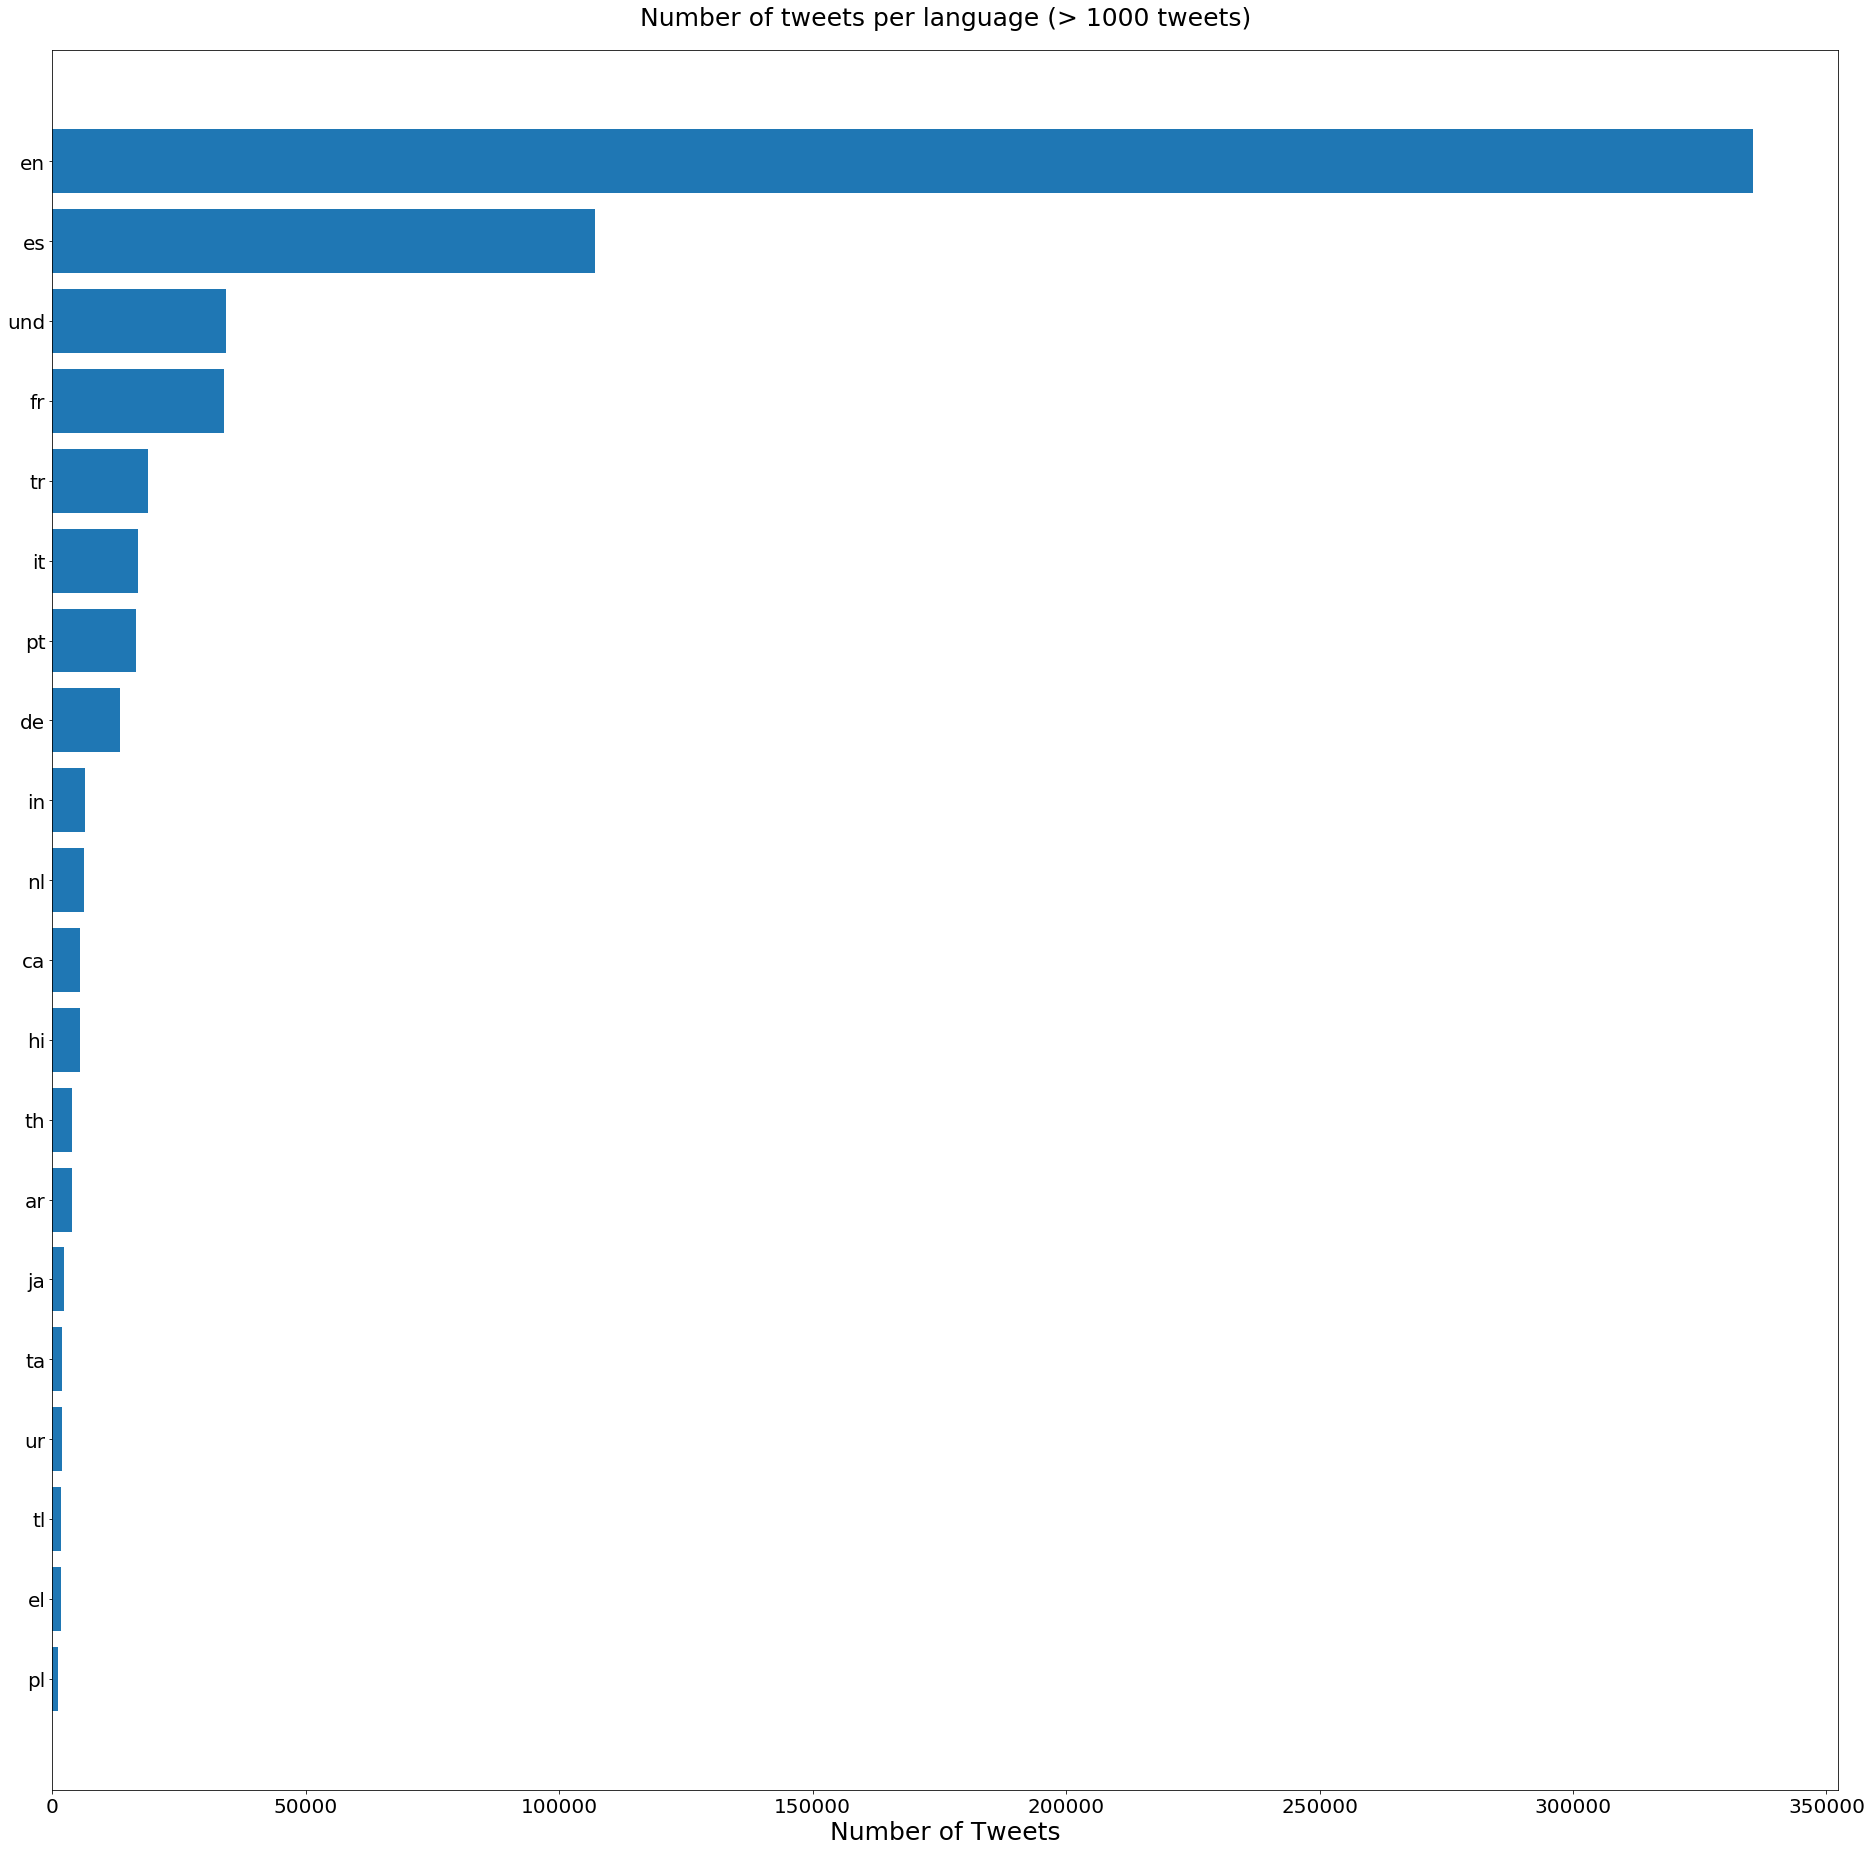

In [30]:
## Group by language
# fig, ax = plt.subplots(figsize=(15,7))
lang_tweets = tweets_df.groupby('lang', as_index=False).count()[['lang','status_id']].sort_values(by=['status_id'])
lang_tweets = lang_tweets[lang_tweets['status_id'] > 1000]
plt.figure(figsize=(32,32))
plt.barh(lang_tweets['lang'], lang_tweets['status_id'])
plt.title("Number of tweets per language (> 1000 tweets)")
plt.xlabel("Number of Tweets")
plt.tick_params(labelsize=20)
plt.show()

## Bar graph for tweets based on country

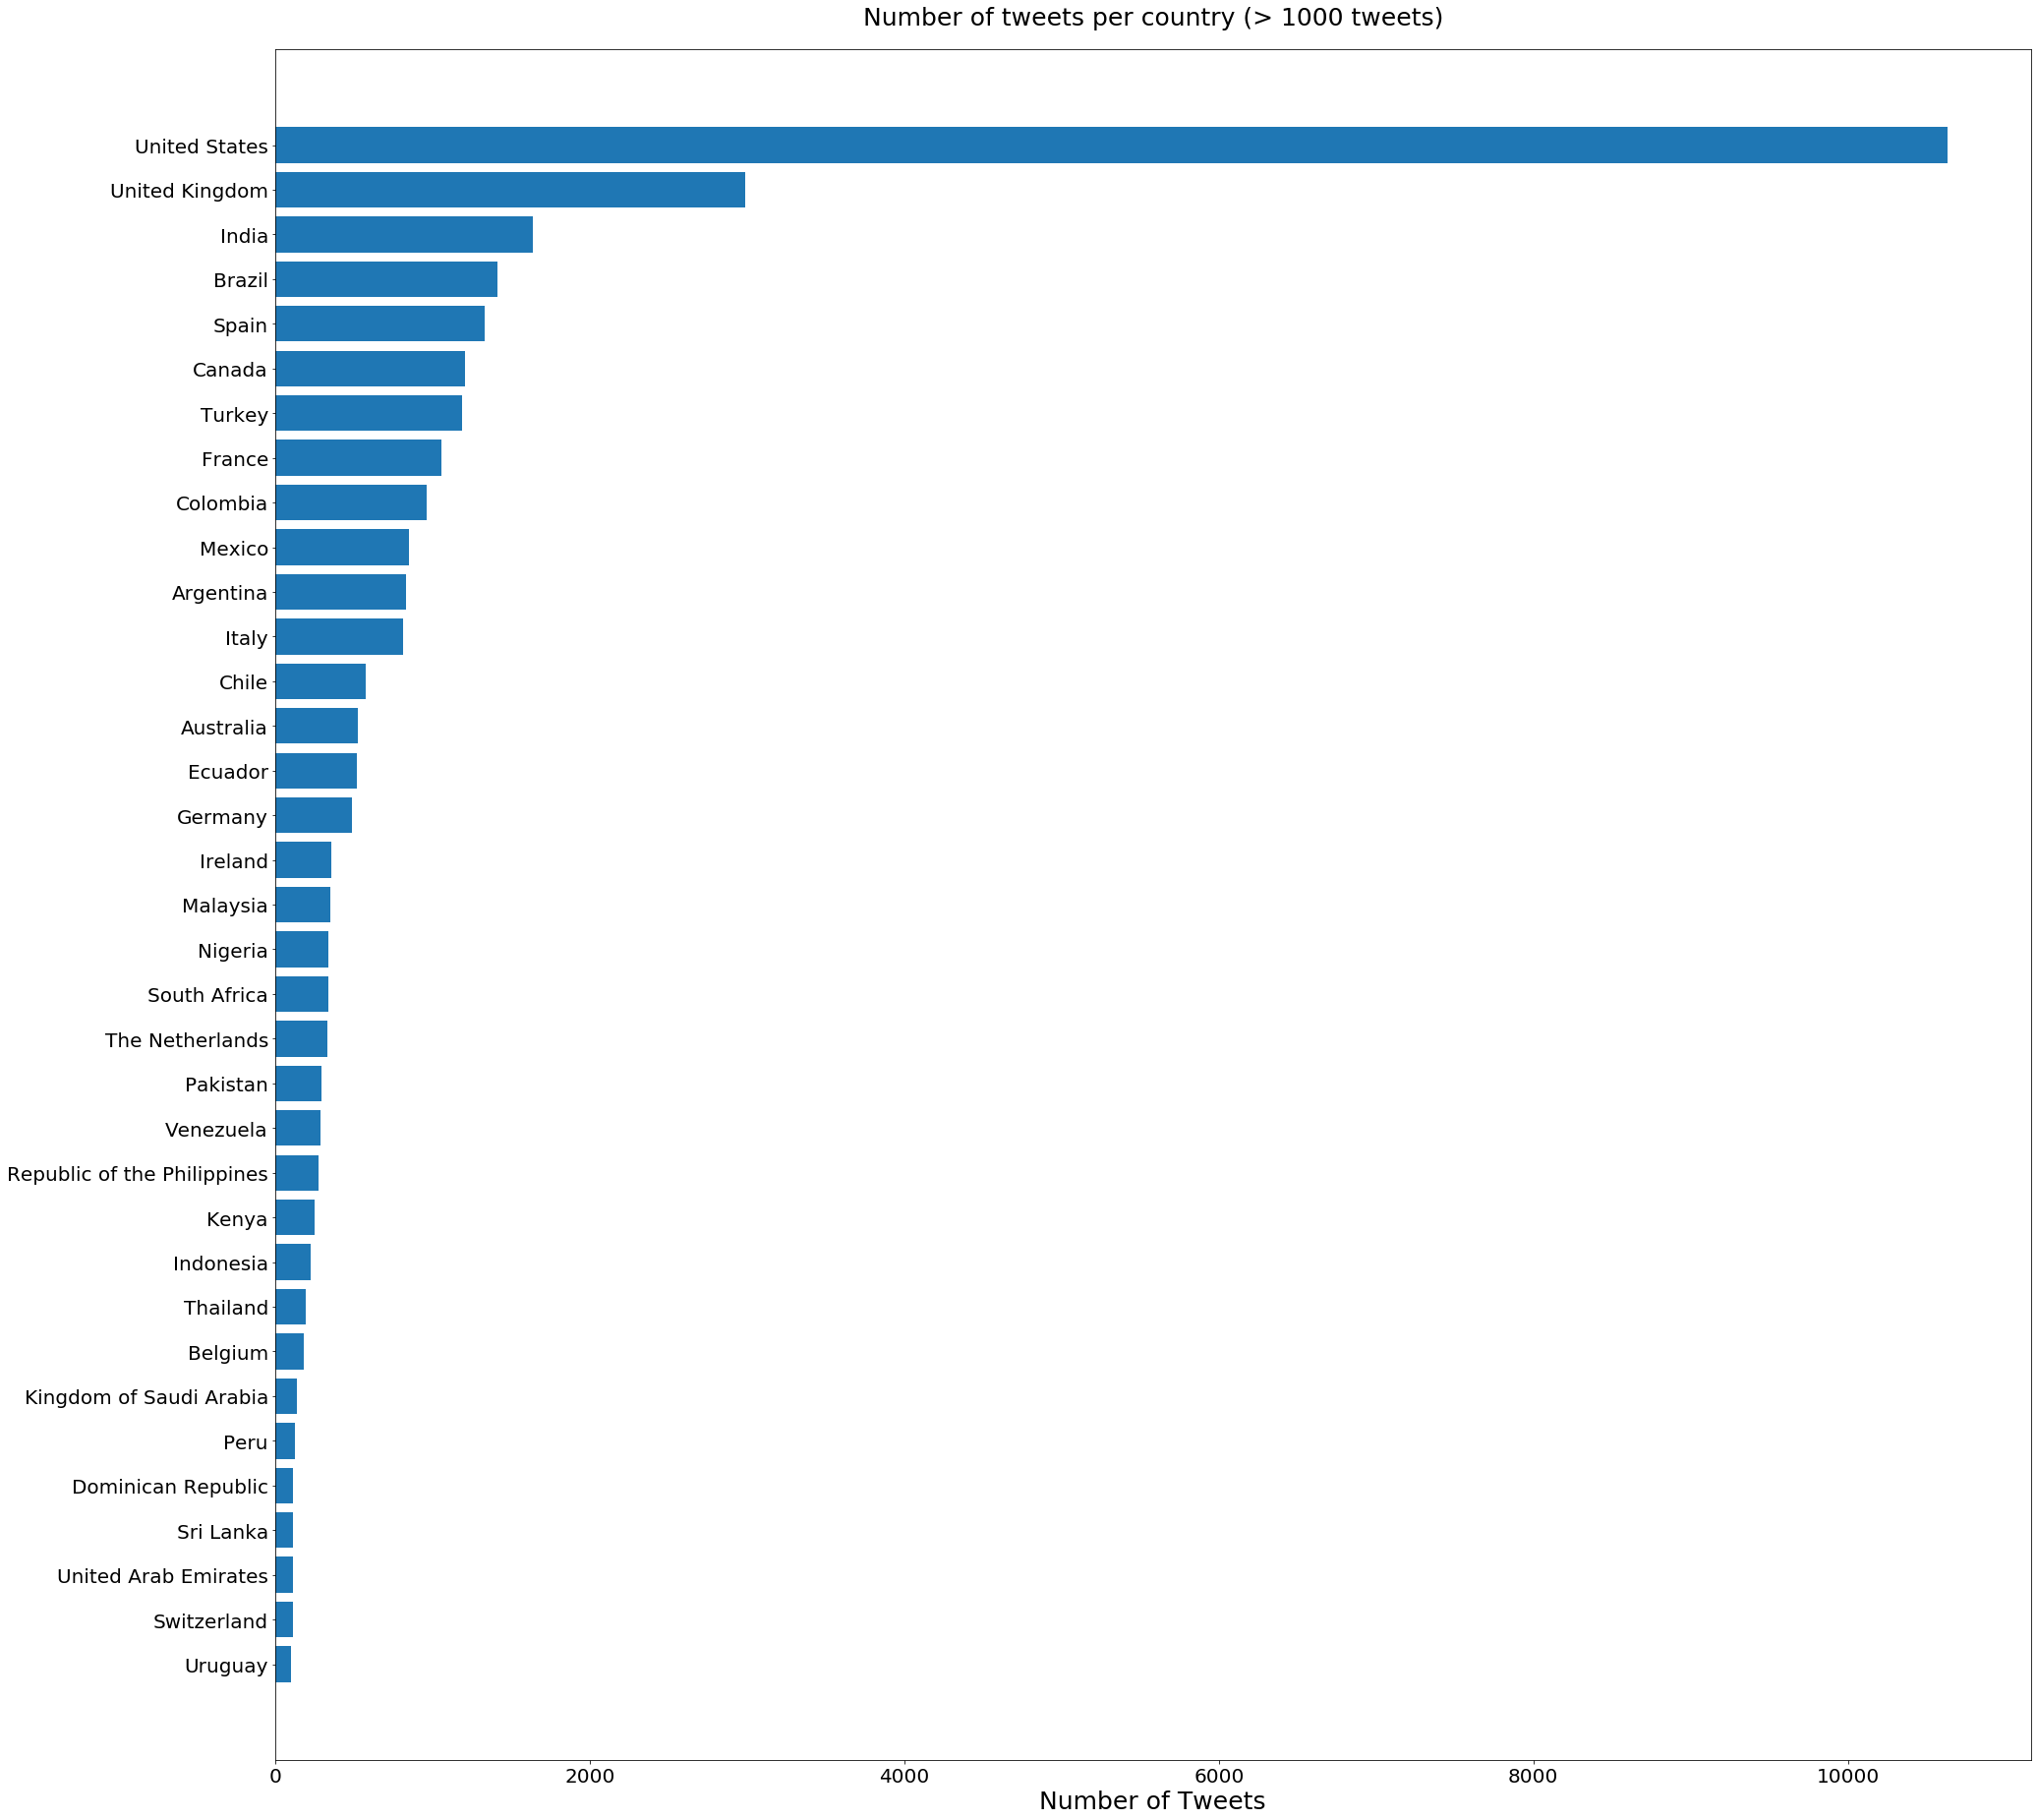

In [31]:
## Group by country
# fig, ax = plt.subplots(figsize=(15,7))
lang_tweets = tweets_df.groupby('country', as_index=False).count()[['country','status_id']].sort_values(by=['status_id'])
lang_tweets = lang_tweets[lang_tweets['status_id'] > 100]
plt.figure(figsize=(32,32))
plt.barh(lang_tweets['country'], lang_tweets['status_id'])
plt.title("Number of tweets per country (> 1000 tweets)")
plt.xlabel("Number of Tweets")
plt.tick_params(labelsize=20)
plt.show()

## Bar chart based on the medium used to tweet

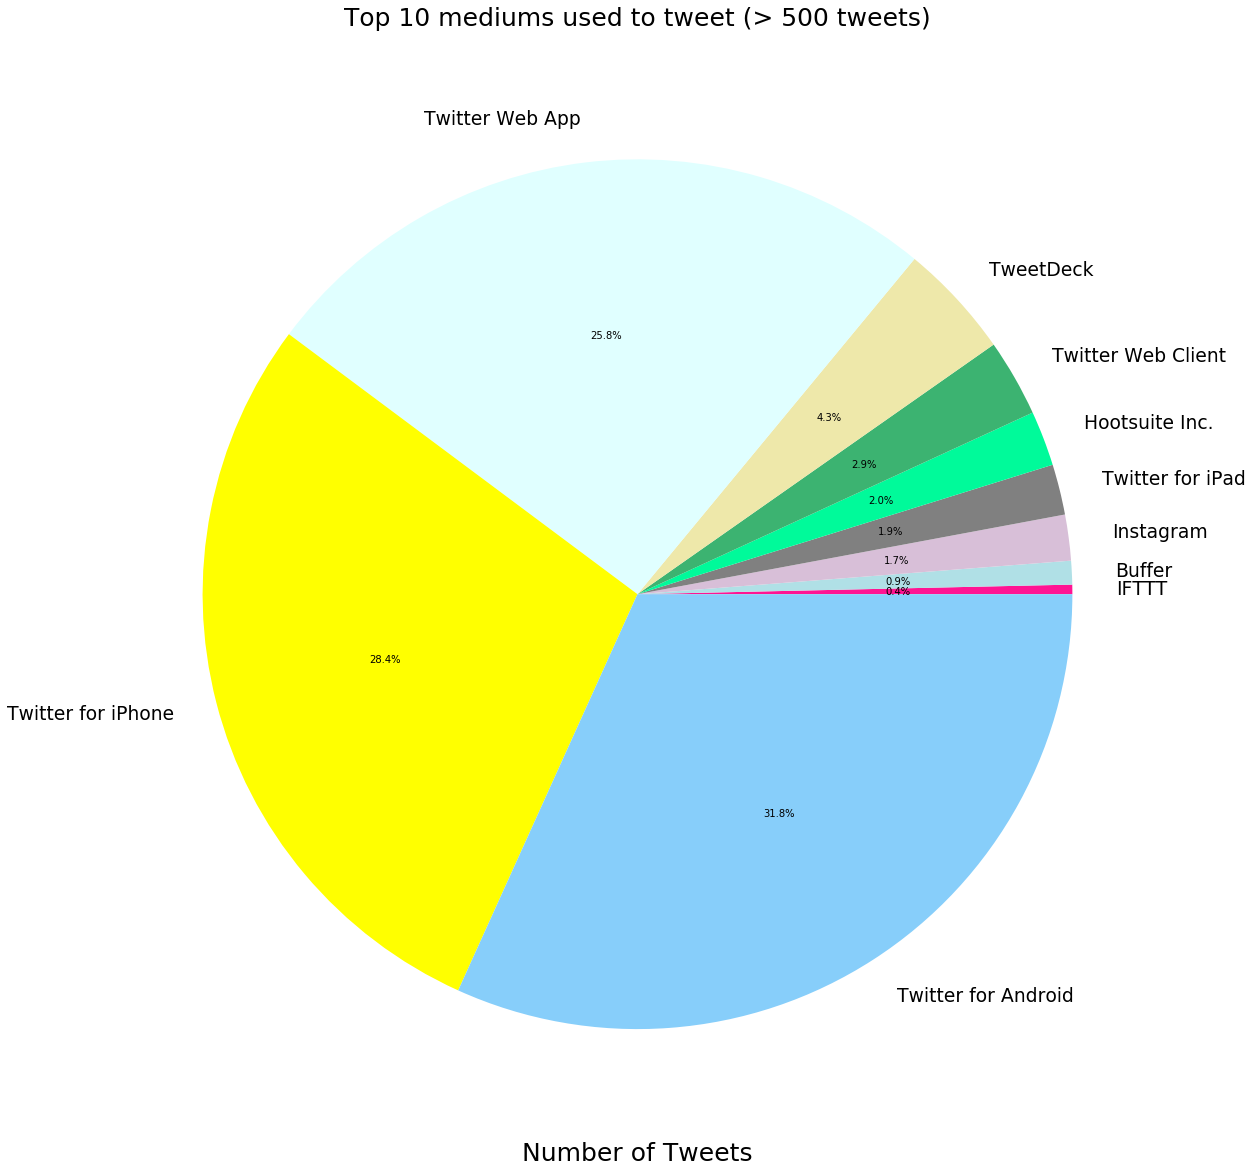

In [56]:
import random
import matplotlib.colors as mcolors

source_tweets = tweets_df.groupby('source', as_index=False).count()[['source','status_id']].sort_values(by=['status_id'])
source_tweets = source_tweets[source_tweets['status_id'] > 2000]
plt.figure(figsize=(20,20))
colors = random.choices(list(mcolors.CSS4_COLORS.values()), k = len(source_tweets))
plt.pie(source_tweets['status_id'], colors=colors, autopct='%1.1f%%', labels=source_tweets['source'])
# plt.legend(source_tweets['source'], loc="best")
plt.title("Top 10 mediums used to tweet (> 500 tweets)")
plt.xlabel("Number of Tweets")
plt.show()

## Data Cleaning
* Filter to only North American tweets
* Filter for english only tweets
* Make sure it's got some likes
* Clean the text